# Climate Risk Analysis of Sierra Club Press Releases

## Project Overview

This project aims to analyze Sierra Club press releases to identify and quantify mentions of climate risks, focusing on transition risks and physical risks. We'll use both traditional (TF-IDF) and modern (BERT) NLP techniques to process and analyze the text data.

## Installation

Before we begin, let's install the necessary packages for this lab. Run the following cell to install the required libraries:


In [ ]:
%pip install nlp4ss


## Setup and Data Loading

- We import necessary libraries and initialize the project environment using HyFI.
- NLTK data is downloaded for text processing tasks.
- The Sierra Club press release data is loaded from a JSONL file into a pandas DataFrame.


In [1]:
from hyfi import HyFI

if HyFI.is_colab():
    HyFI.mount_google_drive()
    project_root = "/content/drive/MyDrive/nlp4ss"
else:
    project_root = "$HOME/workspace/courses/nlp4ss"

h = HyFI.initialize(
    project_name="nlp4ss",
    project_root=project_root,
    logging_level="INFO",
    verbose=True,
)

print("Project directory:", h.project.root_dir)
print("Project workspace directory:", h.project.workspace_dir)

/home/yjlee/.venvs/nlp4ss/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:hyfi.utils.notebooks:Extension autotime not found. Install it first.
INFO:hyfi.joblib.joblib:initialized batcher with <hyfi.joblib.batcher.batcher.Batcher object at 0x7fcc646ec910>
INFO:hyfi.main.config:HyFi project [nlp4ss] initialized


Project directory: /home/yjlee/workspace/courses/nlp4ss
Project workspace directory: /home/yjlee/workspace/courses/nlp4ss/workspace


In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from functools import lru_cache

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /home/yjlee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yjlee/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yjlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yjlee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the data
raw_data_file = h.project.workspace_dir / "data/raw/articles.jsonl"
rdata = h.load_dataset("json", data_files=raw_data_file.as_posix())
df = rdata["train"].to_pandas()

print(df.info())
print("\nSample of the data:")
print(df.head())

# Sample data
df = df.sample(500, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6354 entries, 0 to 6353
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      6354 non-null   object
 1   timestamp  6354 non-null   object
 2   url        6354 non-null   object
 3   page_url   6354 non-null   object
 4   page       6354 non-null   int64 
 5   content    6354 non-null   object
 6   uuid       6354 non-null   object
dtypes: int64(1), object(6)
memory usage: 347.6+ KB
None

Sample of the data:
                                               title       timestamp  \
0  Sierra Club Urges Commerce Department to Hold ...  April 15, 2024   
1  Sierra Club Statement on BOEM Financial Assura...  April 15, 2024   
2  We Energies Files Third Rate Increase in Three...  April 15, 2024   
3  MEDIA ADVISORY: Oregon Regulators to Hear Conc...  April 12, 2024   
4  Advisory: Special Meeting for County Commissio...  April 12, 2024   

                                

## Define Initial Climate Risk Keywords

- We start with two lists of initial keywords: one for transition risks and another for physical risks.
- These keywords are based on common terms associated with each type of climate risk.

> Bua, G., Kapp, D., Ramella, F., & Rognone, L. (2024). Transition versus physical climate risk pricing in European financial markets: A text-based approach. The European Journal of Finance, 1-35.


In [4]:
# Initial keyword lists
initial_transition_risk_keywords = [
    "EJ/YR",
    "Radiative Forcing",
    "HCFC",
    "Ozone",
    "Bioenergy",
    "Technical Potential",
    "GHG Emissions",
    "Refrigerant",
    "IPCC",
    "GHG",
    "Ozone Layer",
    "Geothermal",
    "Pathways",
    "Exajoules",
    "Biomass",
    "Hydropower",
    "GigaJoules",
    "Photovoltaics",
    "Chlorofluorocarbon",
    "Heat Pumps",
    "Ocean Energies",
    "Carbon Dioxide Capture and Storage",
    "Mitigation Scenarios",
    "Lifecycle",
    "USD/kWh",
    "Fluid",
    "Equivalent CO2",
    "Methane",
    "Halon",
    "Blowing Agent",
    "Aerosols",
    "Leakage",
    "Sustainable Development",
    "UNEP",
    "Montreal Protocol",
    "Anthropogenic",
    "Radiative",
    "Wind Energy",
    "Solar energy",
    "Hydrogen",
    "UNFCCC",
    "Product carbon footprints",
    "report safeguarding",
    "geological storage",
    "direct solar",
    "Reservoir",
    "IEA",
    "anthropogenic",
    "adaptation options",
    "ecosystems",
    "global warming potential",
    "ozone-depleting substances",
    "GTCO2",
    "global warming",
    "primary energies",
    "ocean",
    "atmosphere",
    "EQ/YR",
    "dioxide capture and storage",
    "methane",
    "ocean storage",
    "equivalent",
    "dioxide capture",
    "change mitigation",
    "teap",
    "levels cost",
    "energies systems",
    "life cycle climate performance",
    "mitigation options",
    "capacity factors",
    "TWH/YR",
    "feedstock",
    "foam",
    "solvent",
    "biofuels",
    "ozone depletion",
    "sustainable development",
    "Tco2",
    "MTCO2",
    "MTCO2 EQ",
    "stratospheric",
    "climate systems",
    "troposphere",
    "investment cost",
    "human system",
]

initial_physical_risk_keywords = [
    "coastal",
    "ecosystem services",
    "climate models",
    "wetlands",
    "ipcc",
    "adaptation",
    "ryosphere",
    "ice sheet",
    "biodiversity",
    "species",
    "phytoplankton",
    "antarctic",
    "climate variables",
    "biophysical",
    "ghg",
    "pathways",
    "climate change",
    "precipitation",
    "anthropogenic",
    "coupled model",
    "intercomparison projects",
    "cyclones",
    "climate related",
    "ocean",
    "streamflow",
    "adaptation response",
    "change impacts",
    "observed change",
    "socioeconomic",
    "freshwater",
    "temperature increase",
    "coastal zones",
    "sea level",
    "phenology",
    "future climate",
    "upwelling",
    "fisheries",
    "hazards",
    "general circulation models",
    "nutrient",
    "adaptation",
    "permafrost",
    "arid",
    "reefs",
    "water resources",
    "terrestrial",
    "spatial",
    "coral",
    "land degradation",
    "RCP",
    "adaptation planning",
    "change climate",
    "glaciers",
    "salinity",
    "hydrological variables",
    "sediment",
    "tropical cyclones",
    "latitudes",
    "projected change",
]

In [5]:
def preprocess_text(text):
    # Convert to lowercase and remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and short words
    stop_words = set(stopwords.words("english"))
    tokens = [t for t in tokens if t not in stop_words and len(t) > 3]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


# Preprocess keywords
initial_transition_risk_keywords = [
    preprocess_text(keyword) for keyword in initial_transition_risk_keywords
]
initial_physical_risk_keywords = [
    preprocess_text(keyword) for keyword in initial_physical_risk_keywords
]

# Remove duplicates
initial_transition_risk_keywords = list(set(initial_transition_risk_keywords))
physicalinitial_physical_risk_keywords_risk_keywords = list(
    set(initial_physical_risk_keywords)
)

# Replace space with underscore
initial_transition_risk_keywords = [
    keyword.replace(" ", "_")
    for keyword in initial_transition_risk_keywords
    if len(keyword) > 0
]
initial_physical_risk_keywords = [
    keyword.replace(" ", "_")
    for keyword in initial_physical_risk_keywords
    if len(keyword) > 0
]

print("Number of transition risk keywords:", len(initial_transition_risk_keywords))
print("Transition risk keywords:", initial_transition_risk_keywords)

print("Number of physical risk keywords:", len(initial_physical_risk_keywords))
print("Physical risk keywords:", initial_physical_risk_keywords)

Number of transition risk keywords: 77
Transition risk keywords: ['ozone_depletion', 'capacity_factor', 'blowing_agent', 'ozone', 'gigajoules', 'ozone_layer', 'usdkwh', 'dioxide_capture_storage', 'emission', 'report_safeguarding', 'ocean_energy', 'global_warming', 'ecosystem', 'gtco', 'equivalent', 'heat_pump', 'biomass', 'level_cost', 'reservoir', 'aerosol', 'dioxide_capture', 'ocean', 'mtco', 'unep', 'ipcc', 'technical_potential', 'radiative_forcing', 'solvent', 'feedstock', 'sustainable_development', 'mitigation_scenario', 'adaptation_option', 'mitigation_option', 'energy_system', 'human_system', 'unfccc', 'anthropogenic', 'carbon_dioxide_capture_storage', 'exajoules', 'geological_storage', 'leakage', 'photovoltaics', 'fluid', 'climate_system', 'hydropower', 'chlorofluorocarbon', 'primary_energy', 'foam', 'stratospheric', 'ejyr', 'montreal_protocol', 'methane', 'atmosphere', 'ozonedepleting_substance', 'life_cycle_climate_performance', 'refrigerant', 'solar_energy', 'change_mitigati

## Expand Keywords Using Word Embeddings

- We use pre-trained Word2Vec embeddings to find semantically similar words to our initial keywords.
- The `expand_keywords` function takes a list of keywords and returns an expanded list of related terms.
- We combine the original keywords with the expanded ones to create our final keyword lists.
- This expansion helps capture a broader range of terms related to climate risks, potentially improving our analysis.


In [6]:
%%time

# Load pre-trained word embeddings
word2vec_model = api.load("word2vec-google-news-300")


def expand_keywords(keywords, model, topn=5):
    expanded_keywords = set()
    for keyword in keywords:
        try:
            similar_words = model.most_similar(keyword, topn=topn)
            expanded_keywords.update([word.lower() for word, _ in similar_words])
        except KeyError:
            continue  # Skip words not in the vocabulary
    return list(expanded_keywords)


# Expand keyword lists
expanded_transition_keywords = expand_keywords(
    initial_transition_risk_keywords, word2vec_model
)
expanded_physical_keywords = expand_keywords(
    initial_physical_risk_keywords, word2vec_model
)

# Combine original and expanded keywords
transition_risk_keywords = (
    initial_transition_risk_keywords + expanded_transition_keywords
)
physical_risk_keywords = initial_physical_risk_keywords + expanded_physical_keywords

# Remove duplicates
transition_risk_keywords = list(set(transition_risk_keywords))
physical_risk_keywords = list(set(physical_risk_keywords))

print("Number of expanded transition risk keywords:", len(transition_risk_keywords))
print("Number of expanded physical risk keywords:", len(physical_risk_keywords))

print("Expanded transition risk keywords:", transition_risk_keywords)
print("Expanded physical risk keywords:", physical_risk_keywords)

INFO:gensim.models.keyedvectors:loading projection weights from /home/yjlee/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /home/yjlee/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-08-23T15:50:23.076898', 'gensim': '4.3.3', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-5.15.0-1029-nvidia-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


Number of expanded transition risk keywords: 221
Number of expanded physical risk keywords: 201
Expanded transition risk keywords: ['aerosolized', 'refrigerants', 'oceans', 'radiative_forcing', 'kilowatthours', 'heat_pump', 'climate_change', 'dioxide_capture', 'ozone_smog', 'sustainable_development', 'ocean_storage', 'atmospheric_co2', 'hydrogen_fueling', 'dioxide_capture_storage', 'geological_storage', 'ionosphere', 'equivalents', 'ozone', 'r_###a_refrigerant', 'gigajoules', 'solar_thermal', 'terawatts', 'atlantic_ocean', 'hydrofluorocarbon', 'photovoltaics_pv', 'biorefining', 'product_carbon_footprint', 'cellulosic_ethanol', 'ozone_depleting_substance', 'upper_troposphere', 'dam', 'global_warming', 'usdkwh', 'solvents', 'supply_chain', 'hydro_electric', 'hydrogen_powered', 'ozone_pollution', 'pericardial_sac', 'emission', 'equivilant', 'mesosphere', 'greenhouse_warming', 'methane_gas', 'leakages', 'ecosystem', 'gtco', 'quadrillion_btus', 'reservoirs', 'equivalent', 'ozone_layer', 'oz

## Text Preprocessing

- We define a function to preprocess the text, which includes:
  - Converting to lowercase
  - Tokenizing the text
  - Creating both unigrams and bigrams
- This preprocessing step is crucial for capturing both single words and two-word phrases in our analysis.


In [7]:
# Preprocess text to include bigrams
def preprocess_text_with_bigrams(text):
    # Convert to lowercase and tokenize
    tokens = preprocess_text(text).split()
    # Create unigrams and bigrams
    unigrams = tokens
    bigrams = [f"{tokens[i]}_{tokens[i+1]}" for i in range(len(tokens) - 1)]
    return unigrams + bigrams


# Update the dataframe with preprocessed text including bigrams
df["processed_content_bigrams"] = (
    df["content"].apply(preprocess_text_with_bigrams).apply(" ".join)
)

# Print the updated dataframe
df[["processed_content_bigrams"]].head()

,processed_content_bigrams
5775,april contact emily pomilio emilypomiliosierra...
1840,october contact shiloh hernandez earthjustice ...
4272,december contact courtney bourgoin courtneybou...
80,black household face disproportionately high e...
3133,february contact gabby brown gabbybrownsierrac...


## TF-IDF Analysis

- We use TF-IDF (Term Frequency-Inverse Document Frequency) to analyze the importance of climate risk keywords in each document.
- The TF-IDF vectorizer is configured to use our specific climate risk vocabulary.
- We calculate separate scores for transition risks and physical risks based on the TF-IDF matrix.


In [8]:
%%time

# TF-IDF Analysis with bigrams
tfidf_vectorizer = TfidfVectorizer(
    vocabulary=set(transition_risk_keywords + physical_risk_keywords)
)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["processed_content_bigrams"])

# Calculate risk scores using sum method
df["tfidf_transition_score_sum"] = tfidf_matrix[
    :,
    [
        tfidf_vectorizer.vocabulary_.get(word)
        for word in transition_risk_keywords
        if word in tfidf_vectorizer.vocabulary_
    ],
].sum(axis=1)
df["tfidf_physical_score_sum"] = tfidf_matrix[
    :,
    [
        tfidf_vectorizer.vocabulary_.get(word)
        for word in physical_risk_keywords
        if word in tfidf_vectorizer.vocabulary_
    ],
].sum(axis=1)

# Calculate risk scores using cosine similarity
transition_risk_keywords_vector = tfidf_vectorizer.transform(transition_risk_keywords)
physical_risk_keywords_vector = tfidf_vectorizer.transform(physical_risk_keywords)
df["tfidf_transition_score_sim"] = df["processed_content_bigrams"].apply(
    lambda x: cosine_similarity(
        tfidf_vectorizer.transform([x]), transition_risk_keywords_vector
    ).mean()
)
df["tfidf_physical_score_sim"] = df["processed_content_bigrams"].apply(
    lambda x: cosine_similarity(
        tfidf_vectorizer.transform([x]), physical_risk_keywords_vector
    ).mean()
)

# Normalize scores
for col in [
    "tfidf_transition_score_sum",
    "tfidf_physical_score_sum",
    "tfidf_transition_score_sim",
    "tfidf_physical_score_sim",
]:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Combine scores
df["tfidf_transition_score"] = (
    df["tfidf_transition_score_sum"] + df["tfidf_transition_score_sim"]
) / 2
df["tfidf_physical_score"] = (
    df["tfidf_physical_score_sum"] + df["tfidf_physical_score_sim"]
) / 2

CPU times: user 765 ms, sys: 4.2 ms, total: 769 ms
Wall time: 768 ms


Top 10 articles by TF-IDF physical risk score (combined):
                              processed_content_bigrams  tfidf_physical_score
3896  government national climate assessment directl...              1.000000
2715  tongass national forest jeopardized push aband...              0.767211
1199  group file petition affidavit louisiana offici...              0.718412
4442  october contact trey pollard treypollardsierra...              0.714806
3494  september contact adam beitman adambeitmansier...              0.711288
3386  october contact gabby brown sierra club gabbyb...              0.705285
2464  enero contacto javier sierra javiersierrasierr...              0.697268
425   september contact larisa manescu larisamanescu...              0.682795
5889  february contact shane levy shanelevysierraclu...              0.669556
4578  august contact ricky junquera rickyjunquerasie...              0.655046

Top 10 articles by TF-IDF transition risk score (combined):
                       

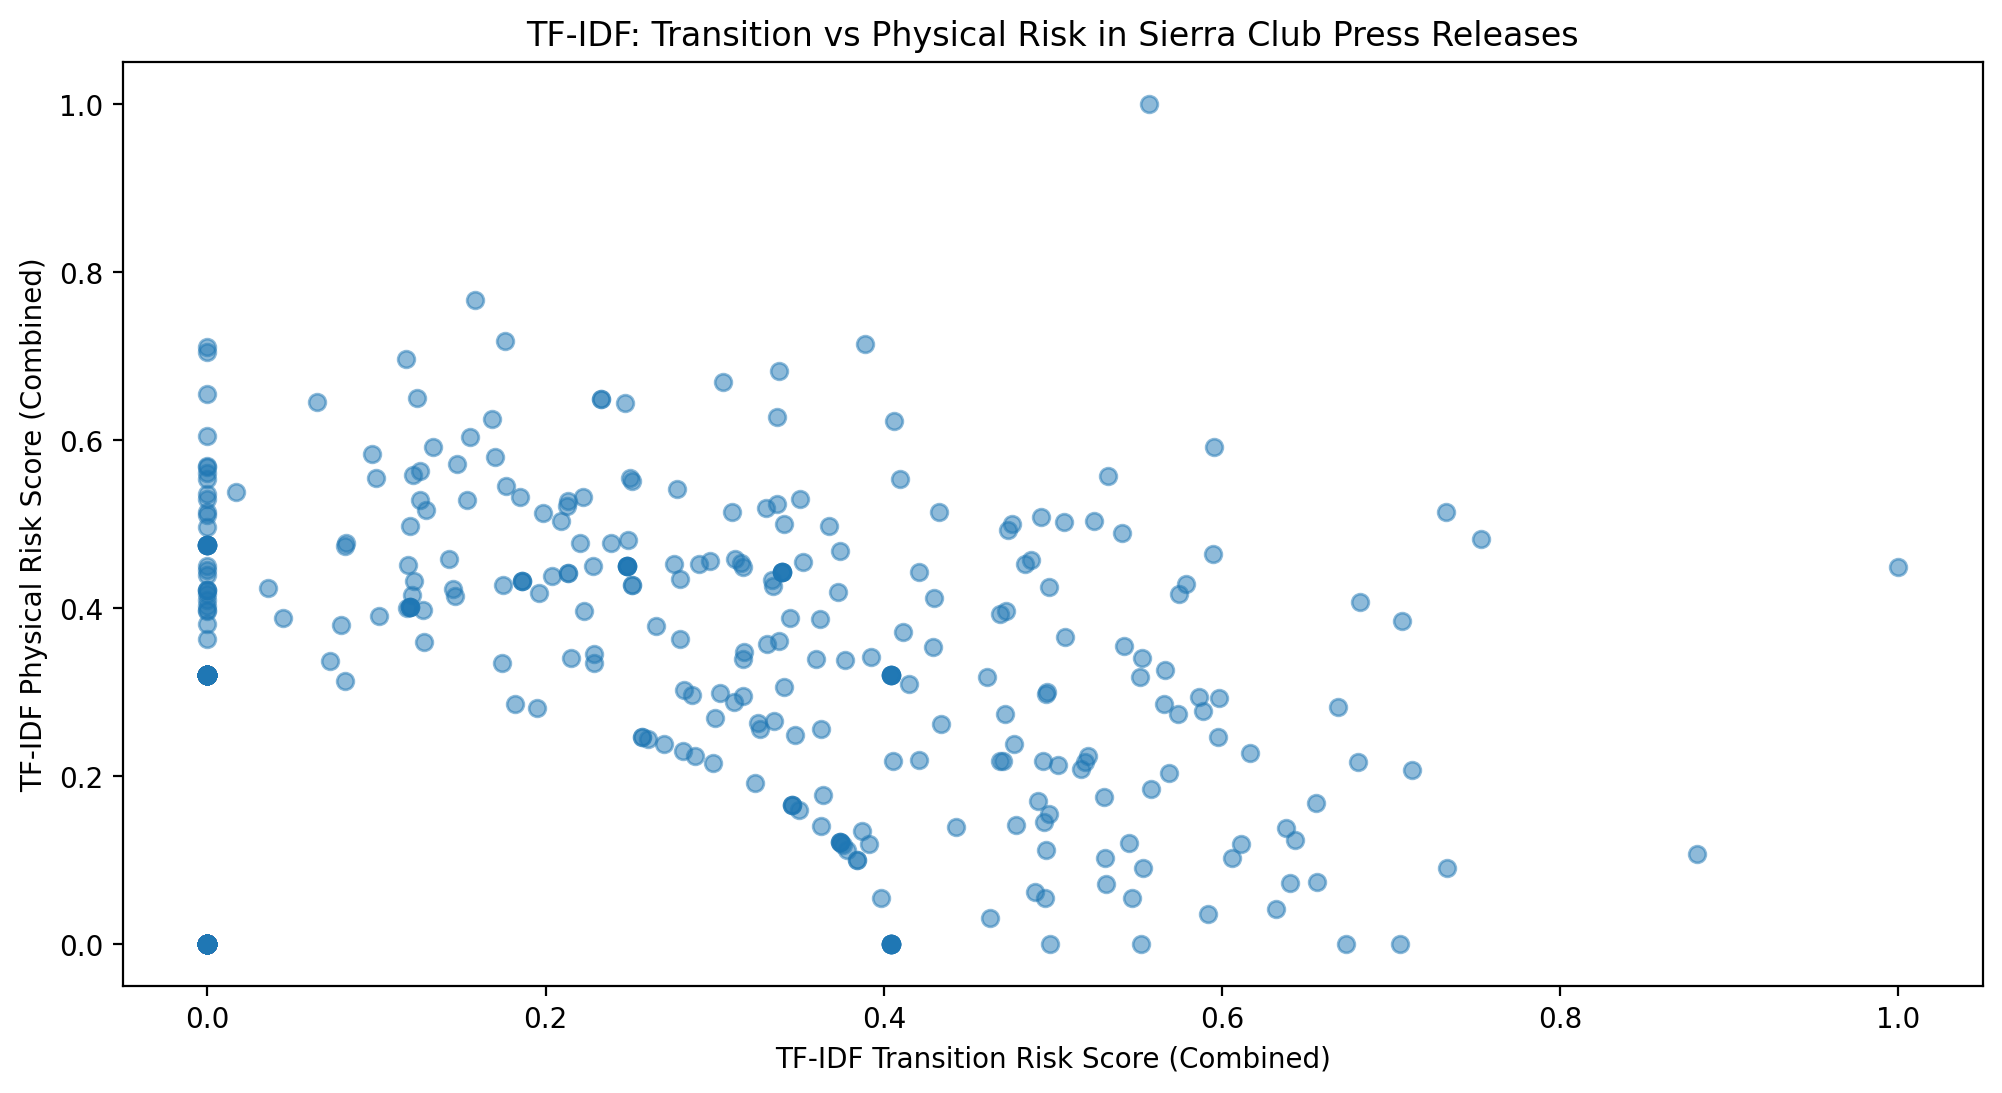

In [9]:
# Display results
print("Top 10 articles by TF-IDF physical risk score (combined):")
print(
    df[["processed_content_bigrams", "tfidf_physical_score"]]
    .sort_values("tfidf_physical_score", ascending=False)
    .head(10)
)

print("\nTop 10 articles by TF-IDF transition risk score (combined):")
print(
    df[["processed_content_bigrams", "tfidf_transition_score"]]
    .sort_values("tfidf_transition_score", ascending=False)
    .head(10)
)

# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(df["tfidf_transition_score"], df["tfidf_physical_score"], alpha=0.5)
plt.xlabel("TF-IDF Transition Risk Score (Combined)")
plt.ylabel("TF-IDF Physical Risk Score (Combined)")
plt.title("TF-IDF: Transition vs Physical Risk in Sierra Club Press Releases")
plt.show()

## BERT-based Analysis

- We use BERT (Bidirectional Encoder Representations from Transformers) for a more context-aware analysis of climate risk mentions.
- The `get_bert_embedding` function generates embeddings for text using BERT.
- The `contextual_keyword_importance` function calculates the importance of keywords in the context of each document, considering both semantic similarity (via BERT embeddings) and keyword frequency.
- We calculate BERT-based scores for both transition and physical risks.


In [10]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Use a model better suited for short text/keywords
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model = model.to(device)

Using device: cuda


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2


In [11]:
%%time

@lru_cache(maxsize=1000)
def get_keyword_embedding(keyword):
    return model.encode(keyword.replace('_', ' '), convert_to_tensor=True).to(device)

def get_embeddings_batch(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch, convert_to_tensor=True).to(device)
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings)

def contextual_keyword_importance(text_embedding, keyword_embeddings, text, keywords):
    attention_scores = torch.cosine_similarity(text_embedding.unsqueeze(0), keyword_embeddings)
    keyword_counts = torch.tensor([text.lower().count(keyword.replace('_', ' ')) for keyword in keywords], device=device)
    importance_scores = attention_scores * keyword_counts
    return importance_scores.sum().item()

print("Pre-computing keyword embeddings...")
transition_keyword_embeddings = torch.stack([get_keyword_embedding(k) for k in transition_risk_keywords])
physical_keyword_embeddings = torch.stack([get_keyword_embedding(k) for k in physical_risk_keywords])

print("Computing document embeddings...")
doc_embeddings = get_embeddings_batch(df['content'].tolist())

print("Calculating BERT-based risk scores...")
transition_scores = []
physical_scores = []

for text, embedding in tqdm(zip(df['content'], doc_embeddings), total=len(df)):
    transition_score = contextual_keyword_importance(embedding, transition_keyword_embeddings, text, transition_risk_keywords)
    physical_score = contextual_keyword_importance(embedding, physical_keyword_embeddings, text, physical_risk_keywords)
    transition_scores.append(transition_score)
    physical_scores.append(physical_score)

df['bert_transition_score'] = transition_scores
df['bert_physical_score'] = physical_scores

print("Normalizing scores...")
for col in ['bert_transition_score', 'bert_physical_score']:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

Pre-computing keyword embeddings...


Batches: 100%|██████████| 1/1 [00:00<00:00, 525.08it/s]


Computing document embeddings...


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.02it/s]


Calculating BERT-based risk scores...


100%|██████████| 500/500 [00:01<00:00, 282.53it/s]


Normalizing scores...
CPU times: user 4.46 s, sys: 263 ms, total: 4.72 s
Wall time: 5.38 s


## Results Analysis and Visualization

- We display the top 10 articles for each risk type and analysis method.
- Scatter plots are created to visualize the relationship between transition and physical risk scores for both TF-IDF and BERT methods.


Top 10 articles by TF-IDF transition risk score:
                                                content  \
393   October 2, 2023\n\n\nContact\nAmy Dominguez, A...   
208   When Fully-Constructed, the 62 Wind Turbines W...   
5925  January 24, 2017\n\n\nContact\nEmily Pomilio (...   
4872  In a unanimous decision, Norman City Council a...   
2847  Businesses Support Bold Action in Energy Moder...   
5058  Mountain Valley Pipeline Announces Plans to Ex...   
2755  September 9, 2020\n\n\nContact\nEmily Pomilio,...   
4050  February 26, 2019\n\n\nContact\nLauren Lantry,...   
4411  Wake County becomes 3rd county in state, 10th ...   
3551  August 29, 2019\n\n\nContact\nTim Cywinski, 54...   

      tfidf_transition_score  
393                 1.000000  
208                 0.880798  
5925                0.753404  
4872                0.732780  
2847                0.732336  
5058                0.712532  
2755                0.706397  
4050                0.705275  
4411                0.

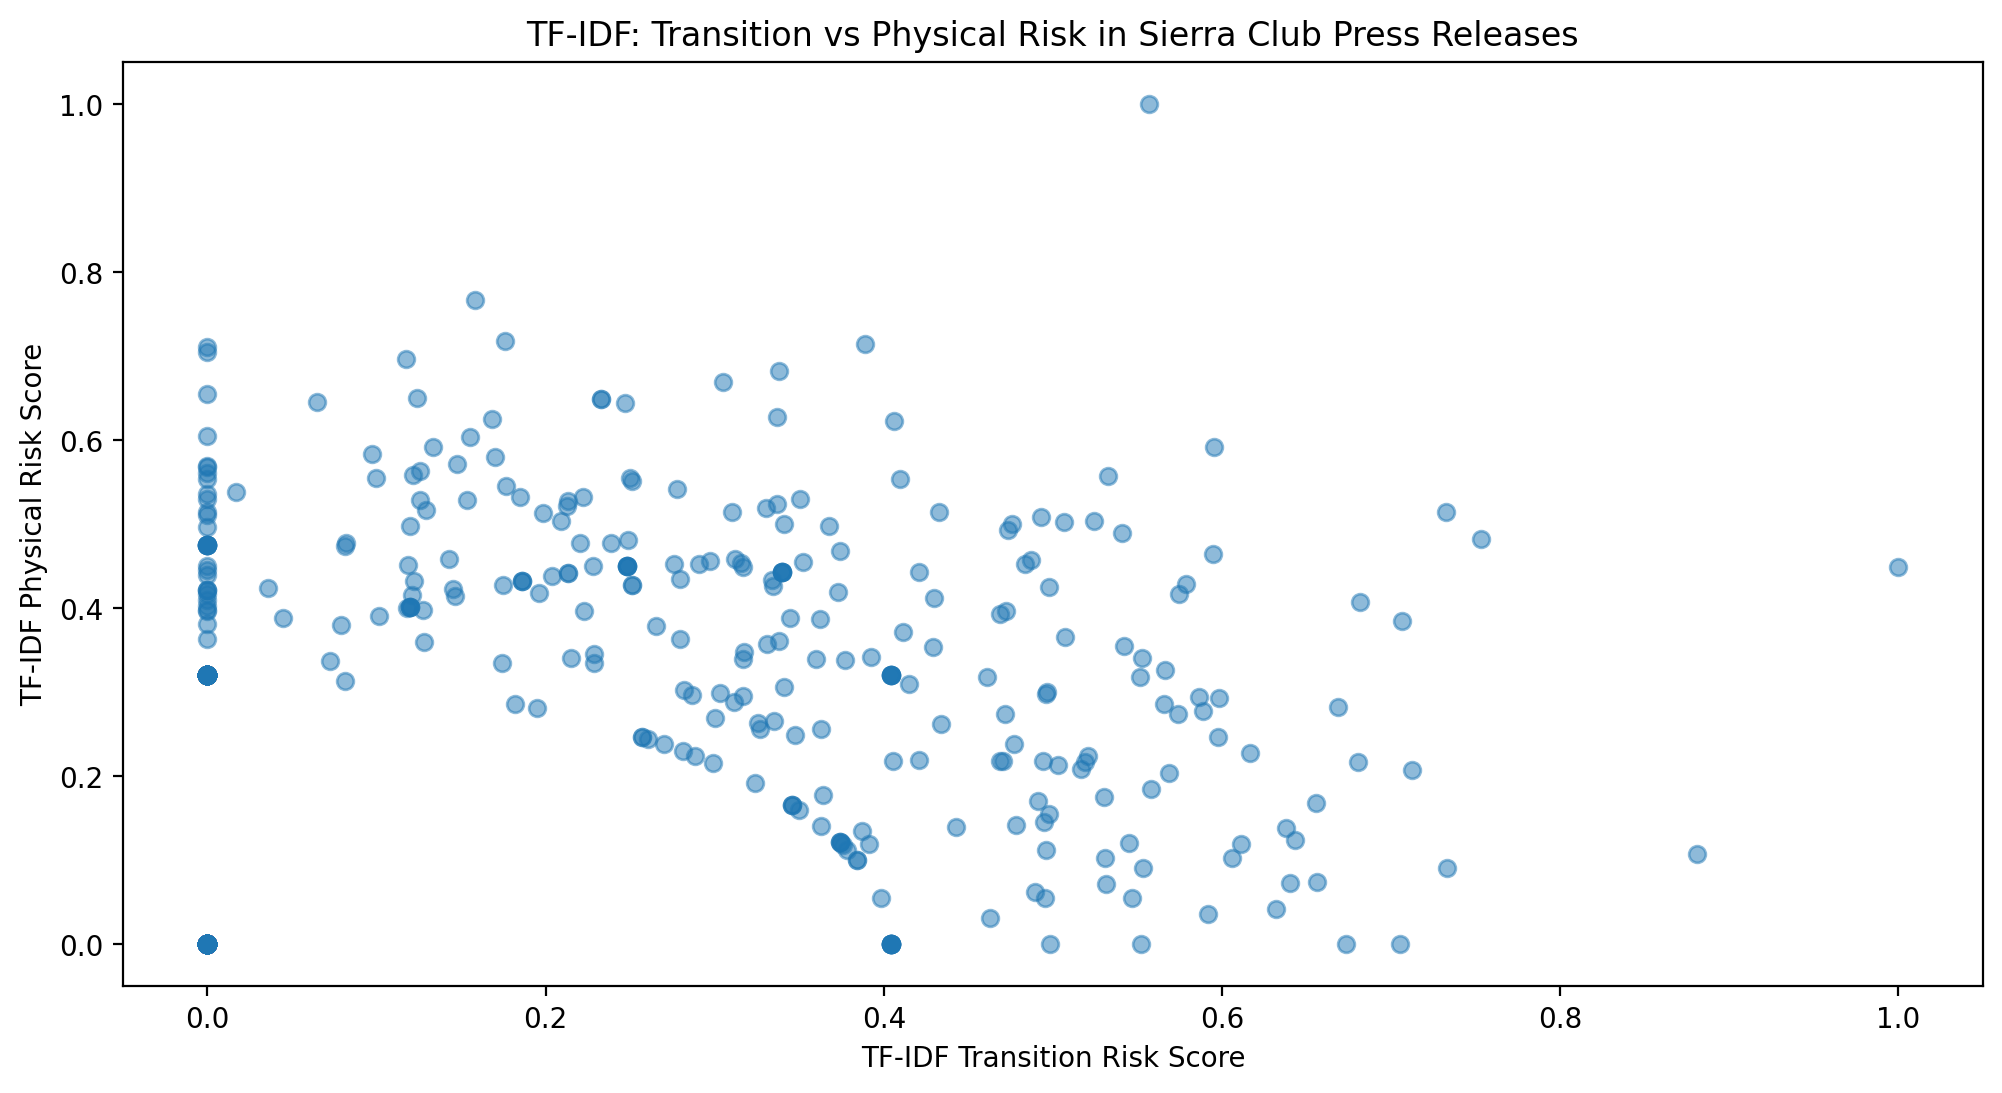

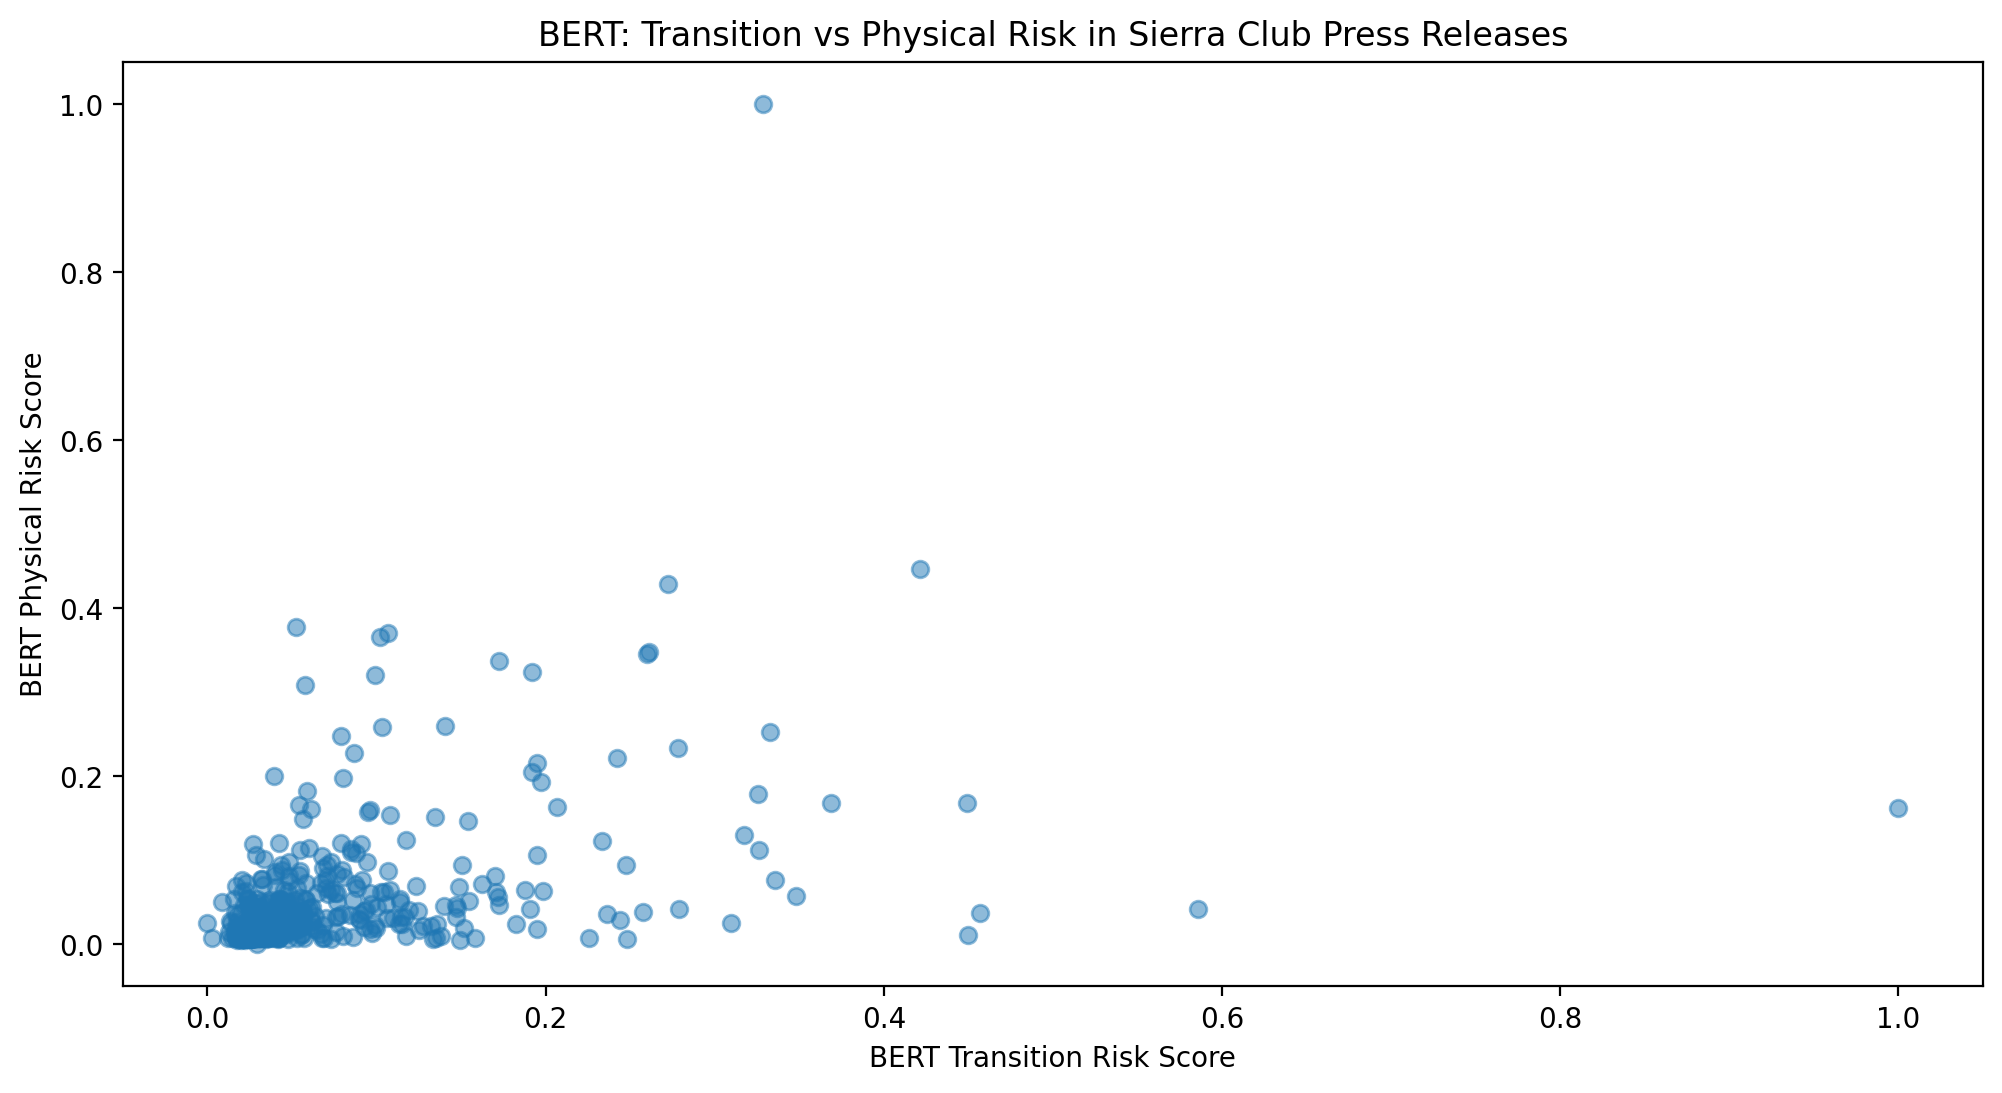

In [12]:
# Display results
print("Top 10 articles by TF-IDF transition risk score:")
print(
    df[["content", "tfidf_transition_score"]]
    .sort_values("tfidf_transition_score", ascending=False)
    .head(10)
)

print("\nTop 10 articles by TF-IDF physical risk score:")
print(
    df[["content", "tfidf_physical_score"]]
    .sort_values("tfidf_physical_score", ascending=False)
    .head(10)
)

print("\nTop 10 articles by BERT transition risk score:")
print(
    df[["content", "bert_transition_score"]]
    .sort_values("bert_transition_score", ascending=False)
    .head(10)
)

print("\nTop 10 articles by BERT physical risk score:")
print(
    df[["content", "bert_physical_score"]]
    .sort_values("bert_physical_score", ascending=False)
    .head(10)
)

# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(df["tfidf_transition_score"], df["tfidf_physical_score"], alpha=0.5)
plt.xlabel("TF-IDF Transition Risk Score")
plt.ylabel("TF-IDF Physical Risk Score")
plt.title("TF-IDF: Transition vs Physical Risk in Sierra Club Press Releases")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(df["bert_transition_score"], df["bert_physical_score"], alpha=0.5)
plt.xlabel("BERT Transition Risk Score")
plt.ylabel("BERT Physical Risk Score")
plt.title("BERT: Transition vs Physical Risk in Sierra Club Press Releases")
plt.show()

## Time Series Analysis

- We convert the timestamp to a datetime index and resample the data to monthly averages.
- A time series plot is created to show how different risk scores change over time.


<Figure size 1400x700 with 0 Axes>

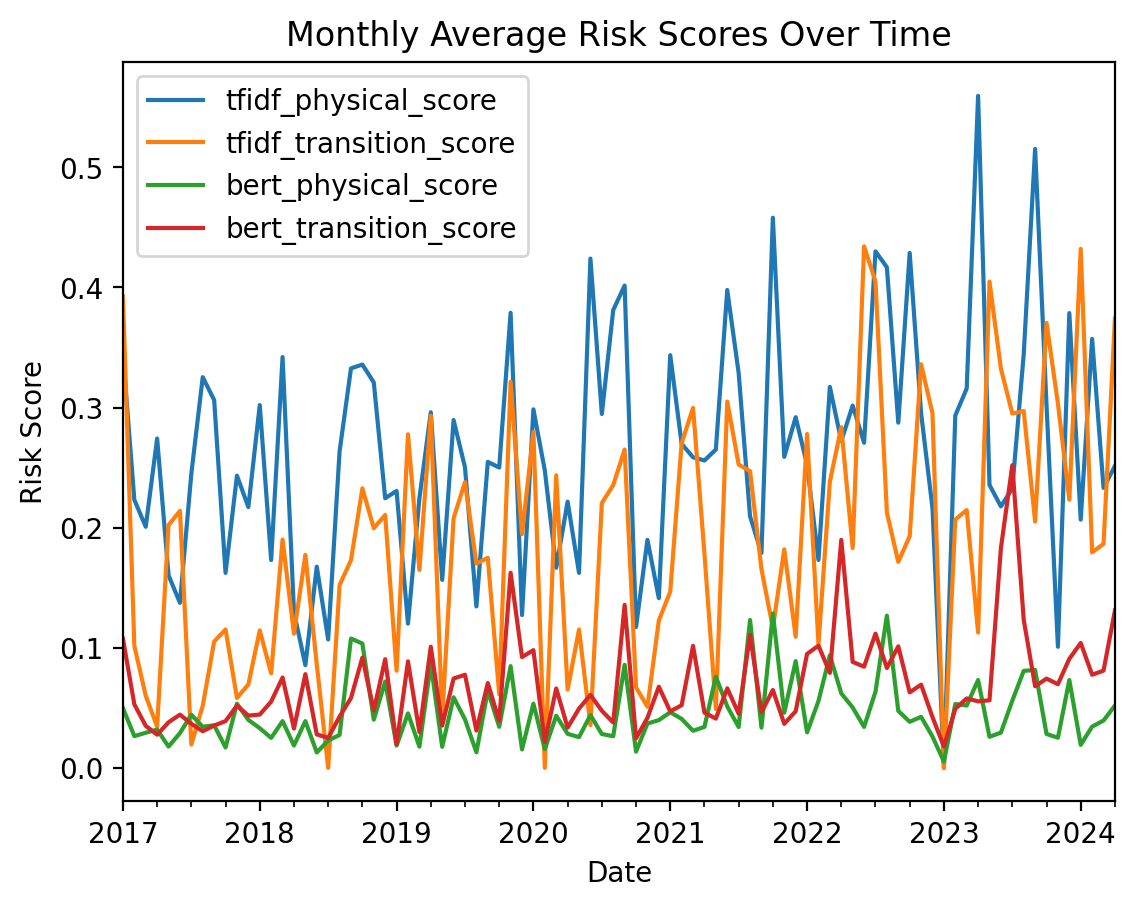

In [13]:
# Time series analysis
df["date"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["date"])
df.set_index("date", inplace=True)

# Monthly average risk scores
monthly_risks = df.resample("M")[
    [
        "tfidf_physical_score",
        "tfidf_transition_score",
        "bert_physical_score",
        "bert_transition_score",
    ]
].mean()

# Plot time series
plt.figure(figsize=(14, 7))
monthly_risks.plot()
plt.title("Monthly Average Risk Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Risk Score")
plt.legend(loc="best")
plt.show()

## Keyword Frequency Analysis

- We analyze the frequency of each keyword in the entire corpus.
- The results are displayed for the top 20 most frequent keywords in each category.
- Bar plots are created to visualize the top 10 keywords for each risk type.


Top 20 most frequent transition risk keywords:
ormat              1557
emission            777
dam                 450
sea                 375
methane             258
climate_change      237
path                153
ozone               117
ecosystem           111
leak                 90
ethanol              65
hydro                51
ocean                42
pathway              33
ipcc                 30
carbon_dioxide       22
hydrogen             21
equivalent           21
atmosphere           21
carbon_emission      20
dtype: int64

Top 20 most frequent physical risk keywords:
climate           3864
danger             681
coast              390
sea                375
level              306
climate_change     237
specie             179
path               153
coastal            123
wetland             95
hazard              63
ocean               42
nitrogen            36
hazardous           33
pathway             33
ipcc                30
sheet               21
threshold           18


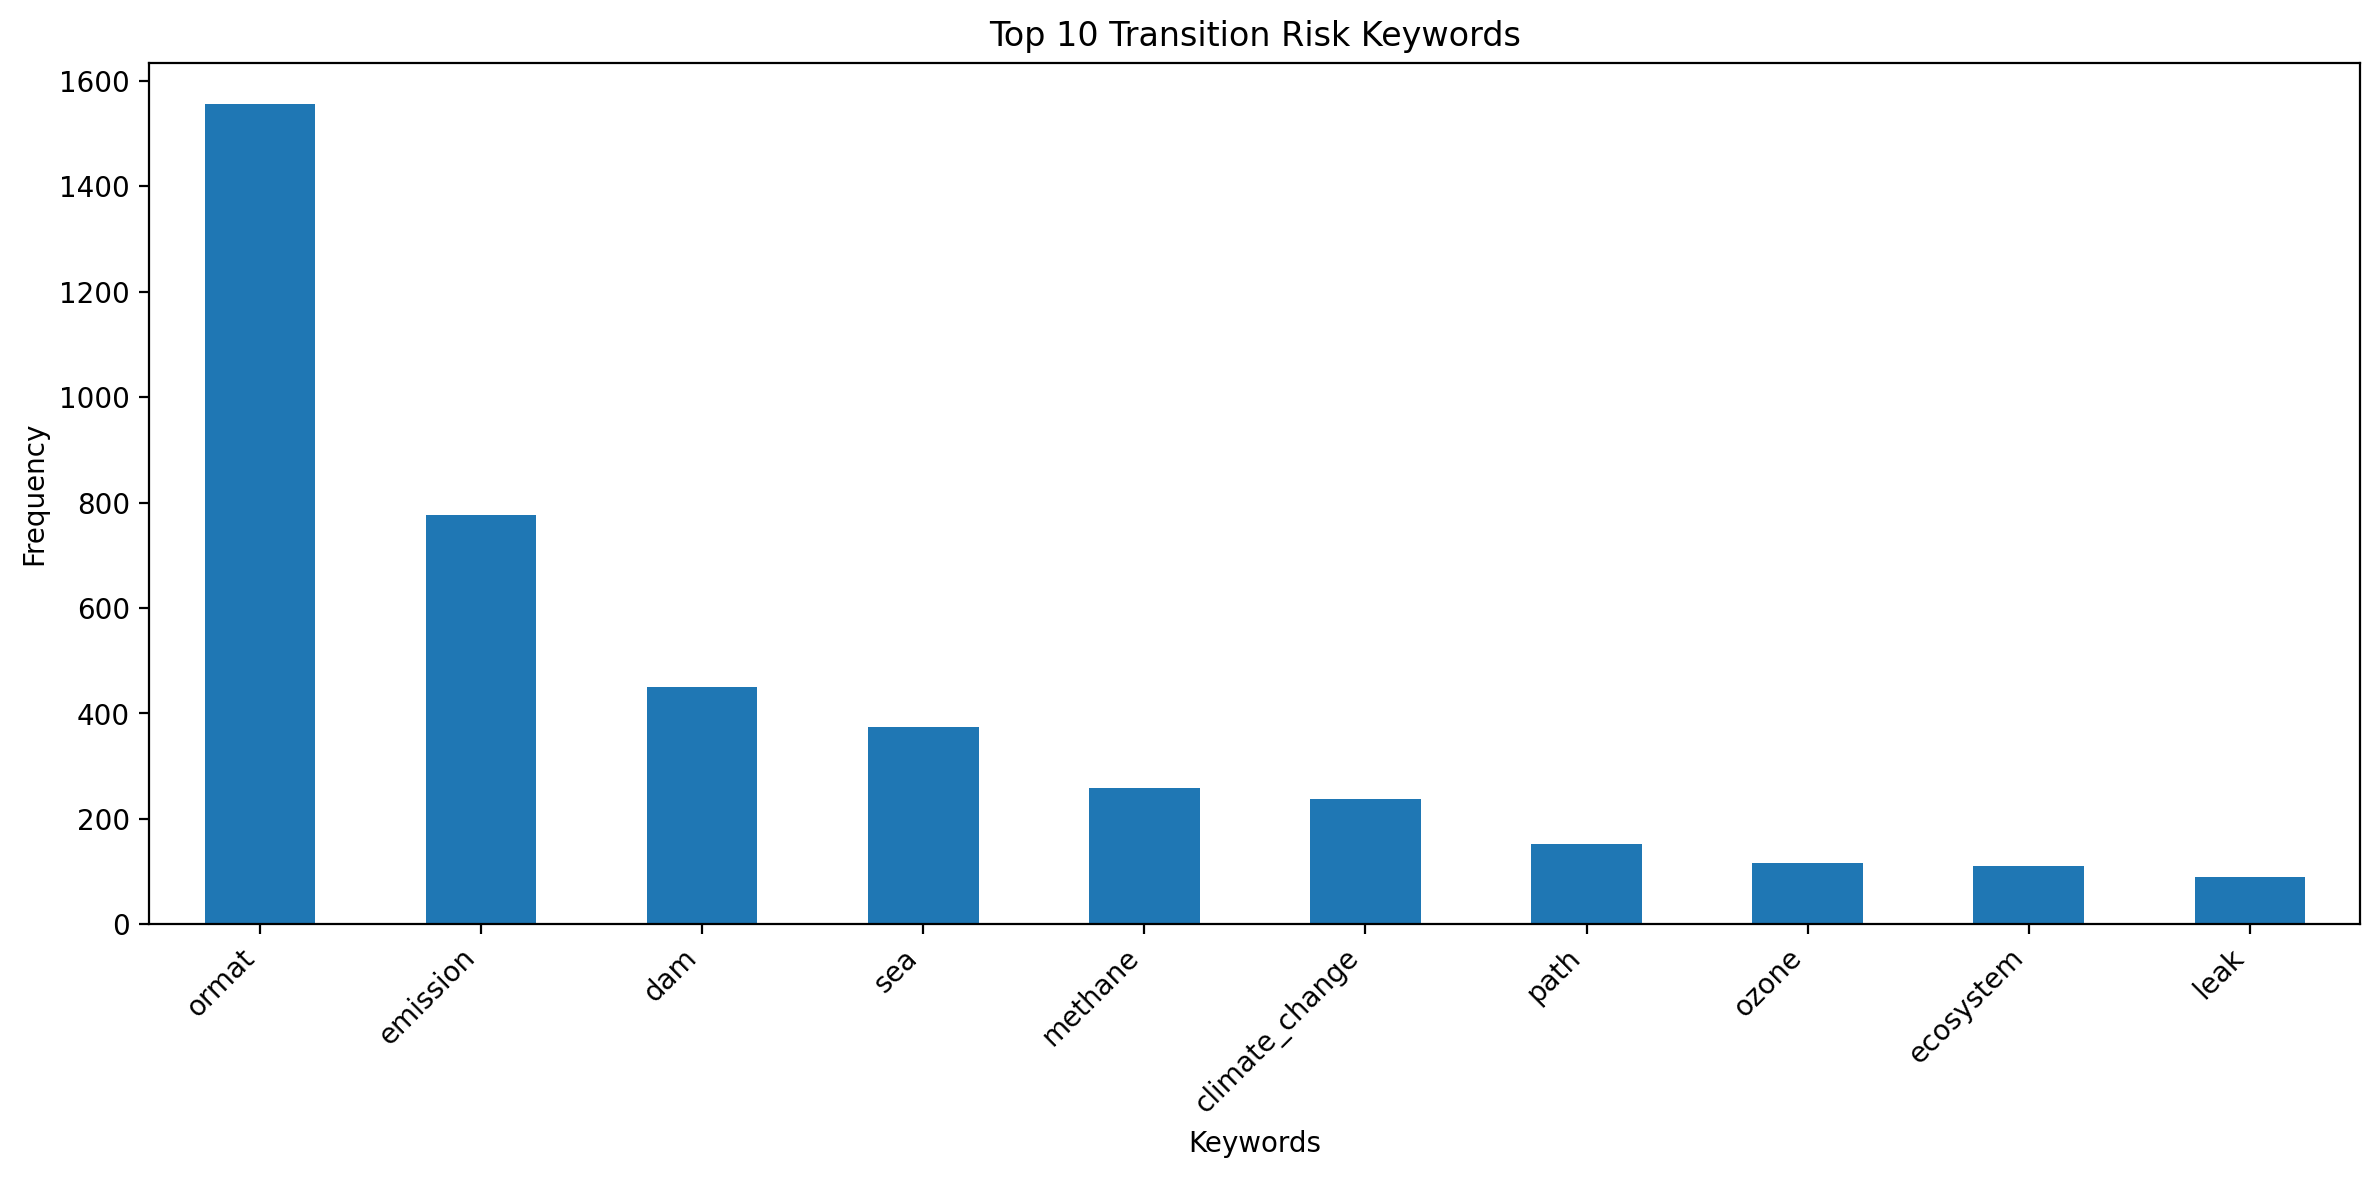

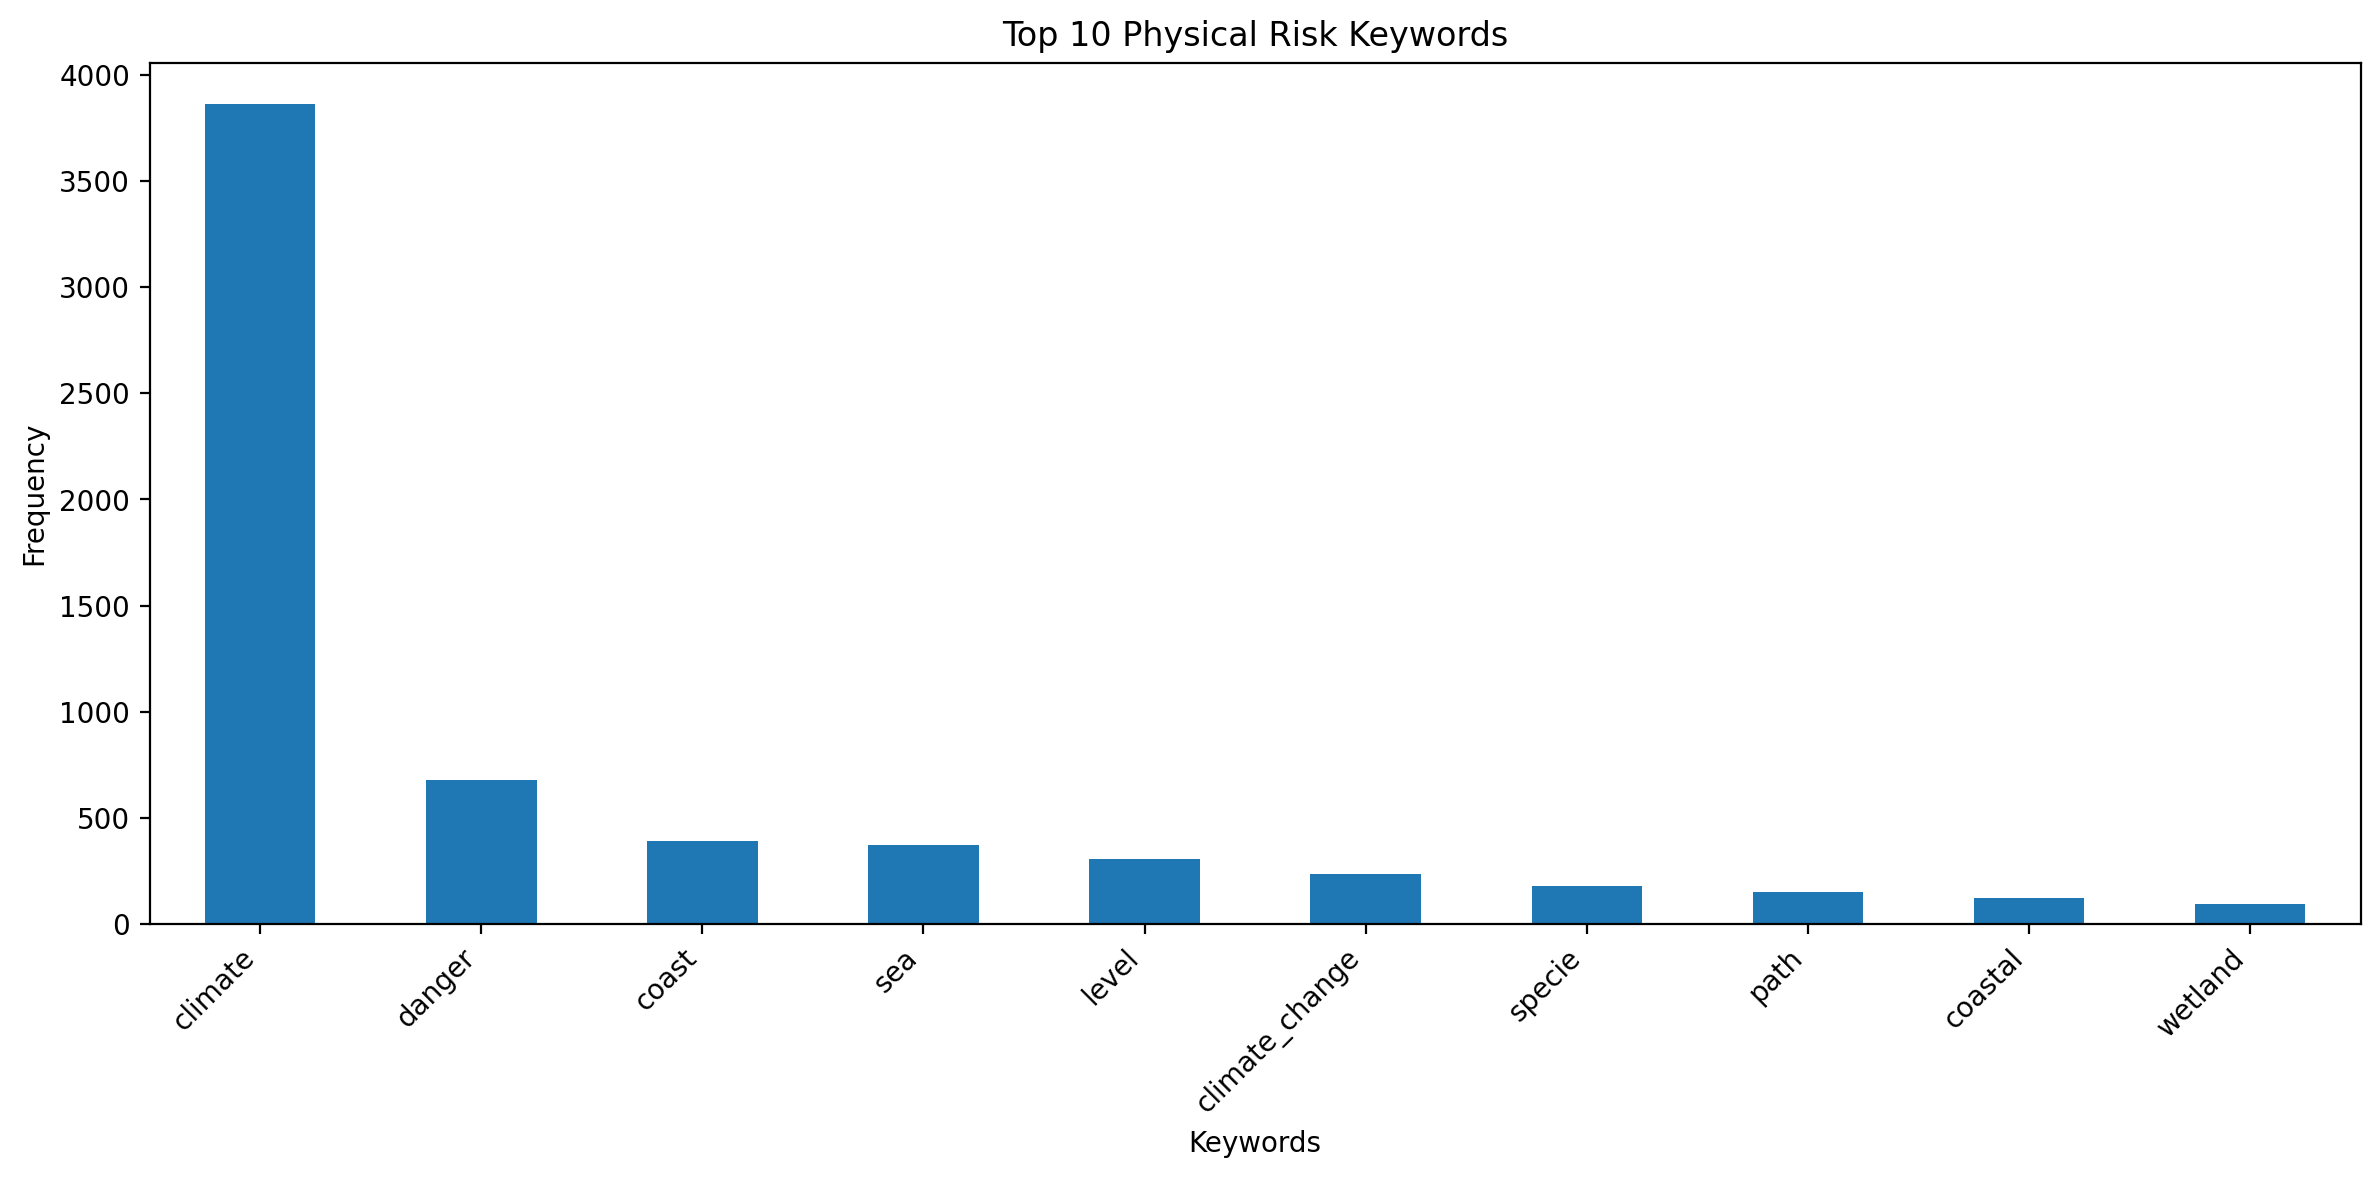

In [14]:
def analyze_keyword_frequency(keywords, df_column):
    keyword_freq = {
        keyword: df_column.apply(lambda x: x.count(keyword.replace("_", " "))).sum()
        for keyword in keywords
    }
    return pd.Series(keyword_freq).sort_values(ascending=False)


transition_freq = analyze_keyword_frequency(
    transition_risk_keywords, df["processed_content_bigrams"]
)
physical_freq = analyze_keyword_frequency(
    physical_risk_keywords, df["processed_content_bigrams"]
)

print("Top 20 most frequent transition risk keywords:")
print(transition_freq.head(20))

print("\nTop 20 most frequent physical risk keywords:")
print(physical_freq.head(20))

# Visualize top keywords
plt.figure(figsize=(12, 6))
transition_freq.head(10).plot(kind="bar")
plt.title("Top 10 Transition Risk Keywords")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
physical_freq.head(10).plot(kind="bar")
plt.title("Top 10 Physical Risk Keywords")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Conclusion

This project presents a comprehensive analysis of climate risk discussions in Sierra Club press releases, utilizing both traditional (TF-IDF) and modern (BERT) NLP techniques. By examining transition and physical risks separately, we gain valuable insights into how different aspects of climate change are addressed in environmental communications.

Key findings and implications:

1. Temporal Trends: The time series analysis reveals evolving patterns in climate risk discourse, potentially reflecting changing priorities or external events influencing the Sierra Club's messaging.

2. Risk Type Comparison: By quantifying the emphasis on transition versus physical risks, we can understand which aspects of climate change receive more attention in the organization's communications.

3. Keyword Analysis: The frequency analysis of specific climate risk terms provides a granular view of the most prominent topics within each risk category, offering insights into the Sierra Club's focus areas.

4. Methodological Comparison: The use of both TF-IDF and BERT-based approaches allows for a nuanced understanding of climate risk mentions, showcasing the strengths and potential complementarity of different NLP techniques.

5. Keyword Expansion Impact: The incorporation of word embeddings to expand our initial keyword lists demonstrates how semantic relationships can enhance the detection of climate risk discussions, potentially capturing more nuanced or varied terminology.

Limitations and Future Directions:

- While keyword expansion increases coverage, it may introduce some noise. Future work could involve refining the expanded keyword list based on domain expertise.
- The analysis could be extended to compare results using initial versus expanded keyword lists to quantify the impact of this approach.
- Experimenting with different word embedding models or expansion techniques could further optimize the keyword selection process.
- Comparative analysis with other environmental organizations' communications could provide broader context for the Sierra Club's approach to climate risk discussion.

This project demonstrates the potential of combining traditional and modern NLP techniques to analyze complex environmental communications. By providing a data-driven approach to understanding climate risk discourse, this analysis can inform strategic communication decisions, policy discussions, and further research in environmental studies and climate change communication.
